In [12]:
import os
import sys

sys.path.insert(0, '../')

from tqdm import tqdm
import logging
import numpy as np
import argparse
import random
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
from utils import test_single_volume
from importlib import import_module
from segment_anything import sam_model_registry
from datasets.dataset_synapse import Synapse_dataset
from icecream import ic
import argparse
import matplotlib.pyplot as plt
from einops import repeat

In [13]:
sam, img_embedding_size = sam_model_registry['vit_b'](image_size=512,
                                                                    num_classes=1,
                                                                    checkpoint='/home/manav/SAMed-mod/checkpoints/sam_vit_b_01ec64.pth', pixel_mean=[0, 0, 0],
                                                                    pixel_std=[1, 1, 1])

pkg = import_module('sam_lora_image_encoder')
net = pkg.LoRA_Sam(sam, 4).cuda()

<class 'int'>


In [14]:
from torchinfo import summary
net.load_lora_parameters('/home/manav/SAMed-mod/output/Train100_100_1_class/Pleural-Effusion_512_pretrain_vit_b_epo200_bs2_lr0.005/epoch_159.pth')
summary(net)

Layer (type:depth-idx)                                  Param #
LoRA_Sam                                                --
├─Sam: 1-1                                              --
│    └─ImageEncoderViT: 2-1                             786,432
│    │    └─PatchEmbed: 3-1                             (590,592)
│    │    └─ModuleList: 3-2                             85,261,824
│    │    └─Sequential: 3-3                             (787,456)
│    └─PromptEncoder: 2-2                               --
│    │    └─PositionEmbeddingRandom: 3-4                --
│    │    └─ModuleList: 3-5                             1,024
│    │    └─Embedding: 3-6                              256
│    │    └─Sequential: 3-7                             4,684
│    │    └─Embedding: 3-8                              256
│    └─MaskDecoder: 2-3                                 --
│    │    └─TwoWayTransformer: 3-9                      3,291,264
│    │    └─Embedding: 3-10                             256
│    │  

In [15]:
net.eval()

LoRA_Sam(
  (sam): Sam(
    (image_encoder): ImageEncoderViT(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (blocks): ModuleList(
        (0-11): 12 x Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): _LoRA_qkv(
              (qkv): Linear(in_features=768, out_features=2304, bias=True)
              (linear_a_q): Linear(in_features=768, out_features=4, bias=False)
              (linear_b_q): Linear(in_features=4, out_features=768, bias=False)
              (linear_a_v): Linear(in_features=768, out_features=4, bias=False)
              (linear_b_v): Linear(in_features=4, out_features=768, bias=False)
            )
            (proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (lin1): Linear(in_features=768, o

<class 'int'>
LUNG1-008_slice105


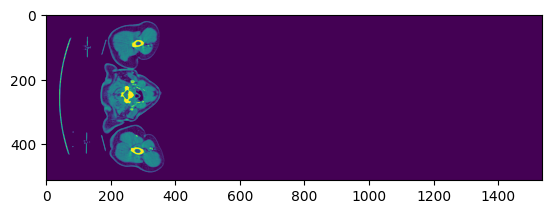

LUNG1-093_slice1


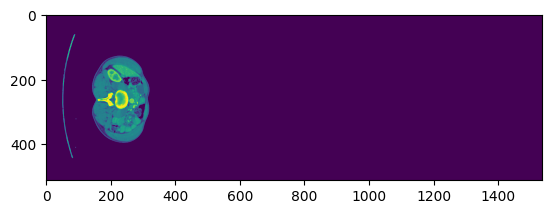

LUNG1-013_slice12


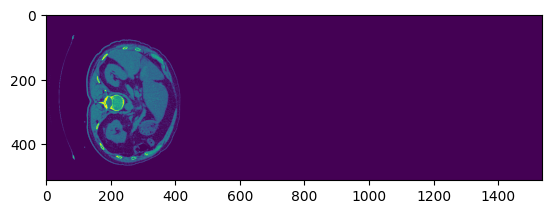

LUNG1-229_slice23


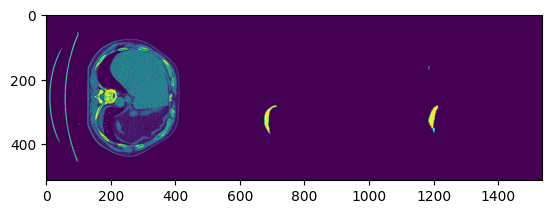

LUNG1-170_slice4


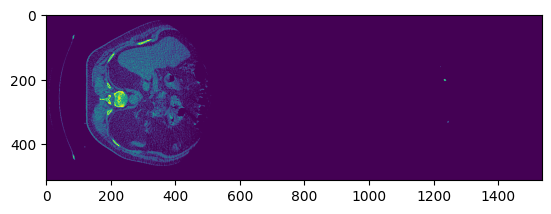

LUNG1-242_slice11


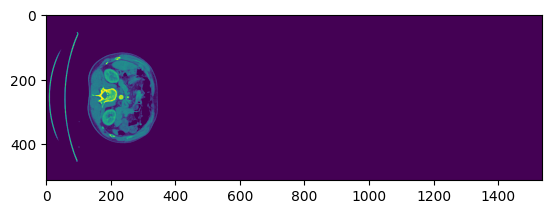

LUNG1-377_slice2


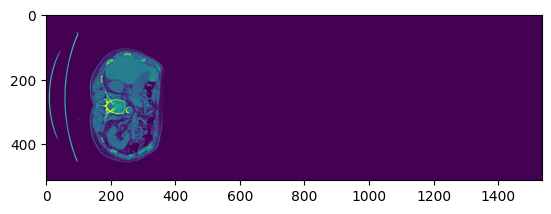

LUNG1-088_slice90


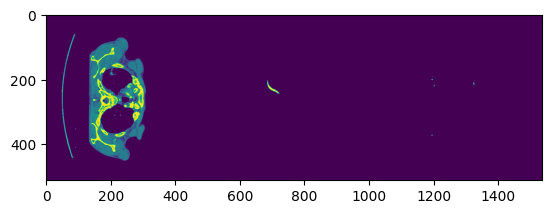

LUNG1-377_slice23


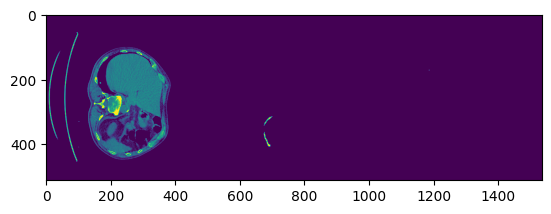

LUNG1-149_slice94


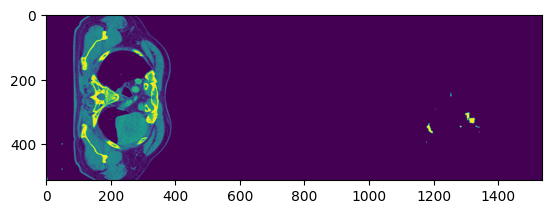

LUNG1-331_slice26


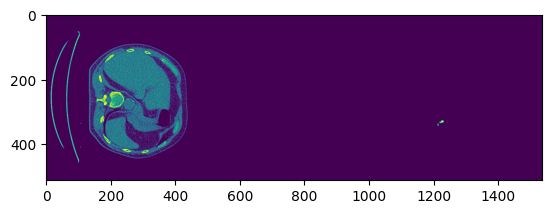

LUNG1-196_slice5


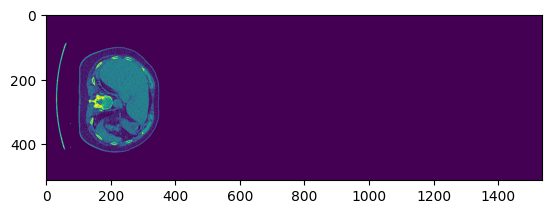

LUNG1-307_slice114


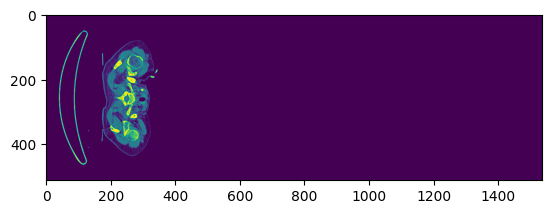

LUNG1-149_slice84


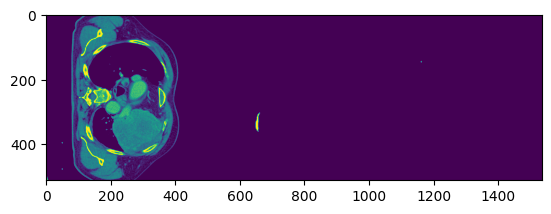

LUNG1-104_slice173


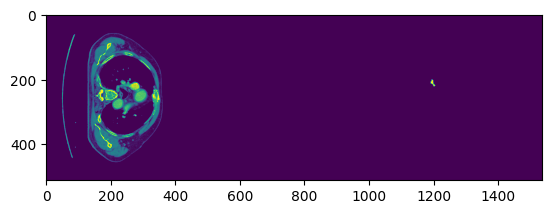

LUNG1-299_slice44


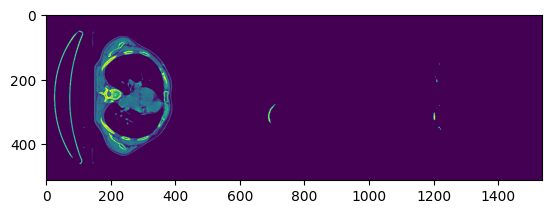

LUNG1-286_slice77


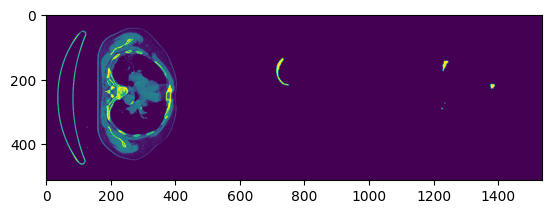

LUNG1-320_slice68


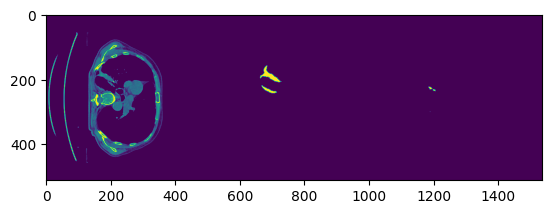

LUNG1-149_slice22


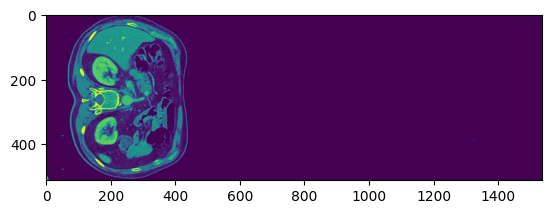

LUNG1-046_slice21


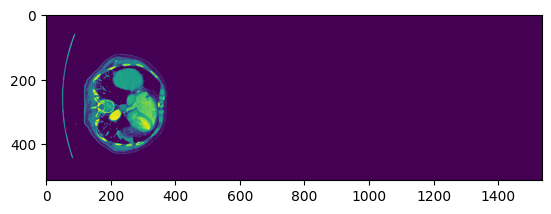

In [22]:
import h5py
import torch

sam, img_embedding_size = sam_model_registry['vit_b'](image_size=512,
                                                      num_classes=1,
                                                      checkpoint='../checkpoints/sam_vit_b_01ec64.pth', pixel_mean=[0, 0, 0],
                                                      pixel_std=[1, 1, 1])

pkg = import_module('sam_lora_image_encoder')
net = pkg.LoRA_Sam(sam, 4).cuda()

net.load_lora_parameters('/home/manav/SAMed-mod/output/Train50_50_1_class/Pleural-Effusion_512_pretrain_vit_b_epo200_bs2_lr0.005/epoch_159.pth')
net.eval()
with open("/home/manav/SAMed-mod/Pleural-Effusion/lists/test.txt", 'r') as file:
    lines = file.readlines()
lines = [i.strip() for i in lines]
random_images = random.sample(lines, 20)
for img_name in random_images:
    print(img_name)
    datapoint = np.load(os.path.join('/home/manav/SAMed-mod/Pleural-Effusion/preprocessed_data/testing_data', f'{img_name}.npz'))
    image = datapoint['image']
    inputs = torch.from_numpy(image).unsqueeze(0).unsqueeze(0).float().cuda()
    inputs = repeat(inputs, 'b c h w -> b (repeat c) h w', repeat=3)
    outputs = net(inputs, True, 512)
    output_masks = outputs['masks']
    out = torch.argmax(torch.softmax(output_masks, dim=1), dim=1).squeeze(0)
    final_disp = np.concatenate((image, datapoint['label'], out.cpu()), axis = 1)
    plt.imshow(final_disp)
    plt.show()

# format of output: Test image | Ground truth | model output

In [19]:
import os
import re
import argparse
import matplotlib.pyplot as plt


directory_mean_dice_dict = {}

def extract_mean_dice(log_file_path):
    try:
        with open(log_file_path, 'r') as log_file:
            log_data = log_file.read()
            
            second_last_line = log_data.split('\n')[-3]
            

            # Regular expression pattern to match mean_dice value
            pattern = r"mean_dice : (\d+\.\d+)"
            mean_dice_value = re.search(pattern, second_last_line)

            if mean_dice_value:
                return float(mean_dice_value.group(1))
            else:
                return None
    except Exception as e:
        print("Error occurred while extracting mean_dice value:", e)
        return None

def plot_directory_vs_loss(directory_mean_dice_dict):
    directory_names = list(directory_mean_dice_dict.keys())
    mean_dice_values = list(directory_mean_dice_dict.values())
    
    plt.figure(figsize=(10, 6))
    plt.plot(directory_names, mean_dice_values, marker='o', linestyle='-')
    plt.title('Directory vs. Mean Dice Value')
    plt.xlabel('Directory')
    plt.ylabel('Mean Dice Value')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def main(directory):


    for root, dirs, files in os.walk(directory):
        if 'test' in dirs:
            test_log_dir = os.path.join(root, 'test', 'test_log')
            if os.path.exists(test_log_dir):
                log_file_path = os.path.join(test_log_dir, 'log.txt')
                if os.path.isfile(log_file_path):
                    mean_dice = extract_mean_dice(log_file_path)
                    if mean_dice is not None:
                        directory_name = os.path.basename(root)
                        directory_mean_dice_dict[directory_name] = mean_dice

    if directory_mean_dice_dict:
        plot_directory_vs_loss(directory_mean_dice_dict)
    else:
        print("No log files found or mean dice values extracted.")

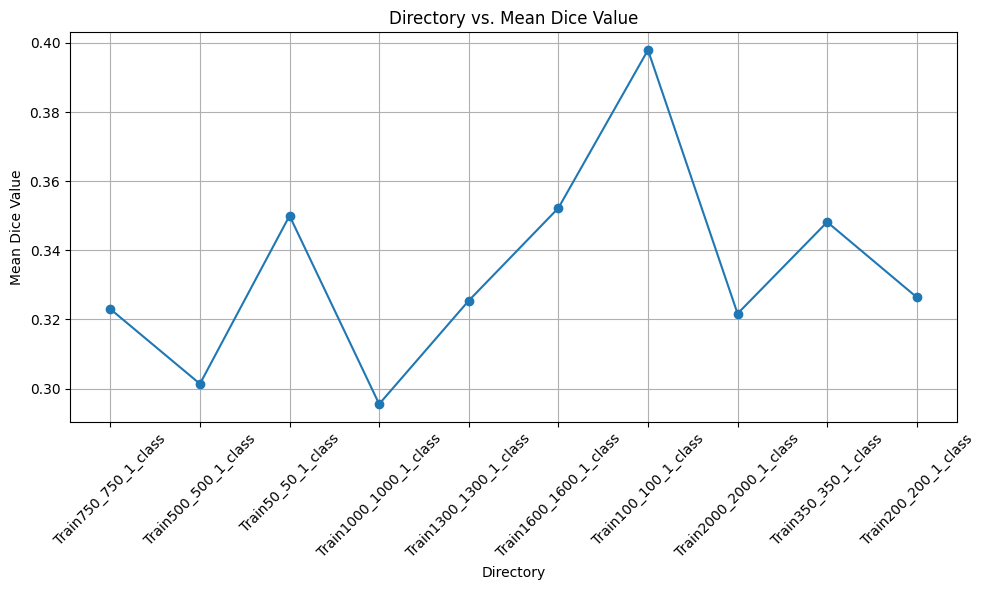

In [20]:
main("/home/manav/SAMed-mod/output")

In [15]:
directory_mean_dice_dict

{'Train750_750_1_class': 0.322998,
 'Train500_500_1_class': 0.301357,
 'Train50_50_1_class': 0.349998,
 'Train1000_1000_1_class': 0.295509,
 'Train1300_1300_1_class': 0.325432,
 'Train1600_1600_1_class': 0.352223,
 'Train100_100_1_class': 0.397951,
 'Train2000_2000_1_class': 0.321674,
 'Train350_350_1_class': 0.348176,
 'Train200_200_1_class': 0.326408}

In [18]:
# Define a function to extract the numeric part from the directory name
def extract_numeric_part(directory_name):
    return int(re.search(r'\d+', directory_name).group())

# Sort the directory names based on the numeric part
sorted_directory_names = sorted(directory_mean_dice_dict, key=extract_numeric_part)

print(sorted_directory_names)

['Train50_50_1_class', 'Train100_100_1_class', 'Train200_200_1_class', 'Train350_350_1_class', 'Train500_500_1_class', 'Train750_750_1_class', 'Train1000_1000_1_class', 'Train1300_1300_1_class', 'Train1600_1600_1_class', 'Train2000_2000_1_class']


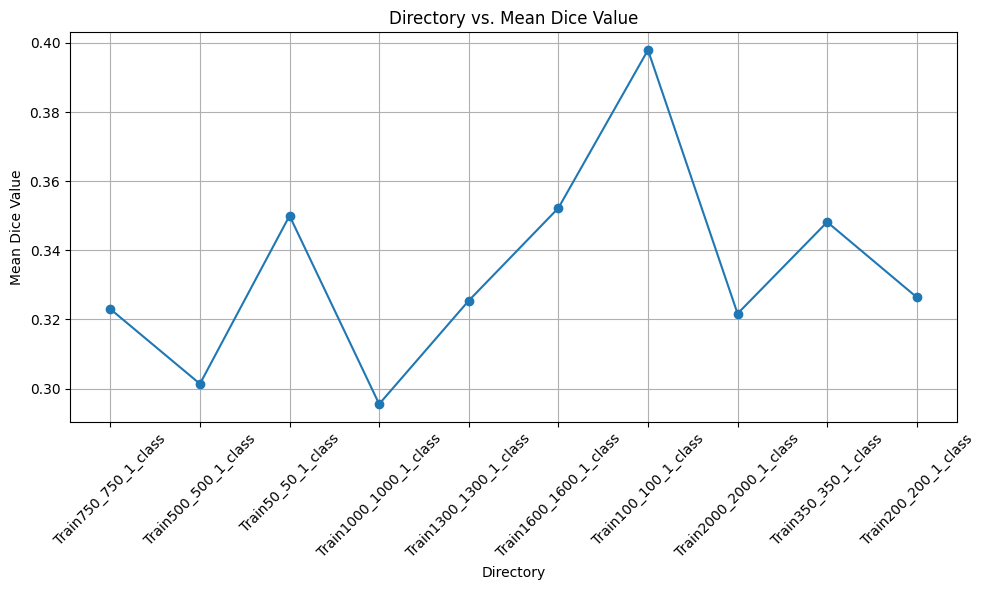

In [19]:
plot_directory_vs_loss(directory_mean_dice_dict)